# Install Dependencies

If you work with a Windows machine, it's better to try LayoutParser on Google Colab instead since it's tricky to install Detectron 2 on Windows machine

**Owner:** Chetan Khadke (khadkechetan@gmail.com)

In [ ]:
%%capture
!sudo apt-get install poppler-utils #pdf2image dependency -- restart runtime/kernel after installation
!sudo apt-get install tesseract-ocr-eng #install Tesseract OCR Engine --restart runtime/kernel after installation

In [ ]:
%%capture
!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install pdf2img
!pip install "layoutparser[ocr]"

In [ ]:
import torchvision.ops.boxes as bops


In [ ]:
import pdf2image
import numpy as np
import layoutparser as lp
# import torchvision.ops.boxes as bops
import torch
import numpy as np
from PIL import Image

# Layout Detection 

In [112]:
pdf_file= '/content/applsci-12-09637-v2.pdf' # Adjust the filepath of your input image accordingly
img = pdf2image.convert_from_path(pdf_file)

In [113]:
type(img)

list

In [114]:
img = img[0]

In [120]:
img1 = np.array(img)

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


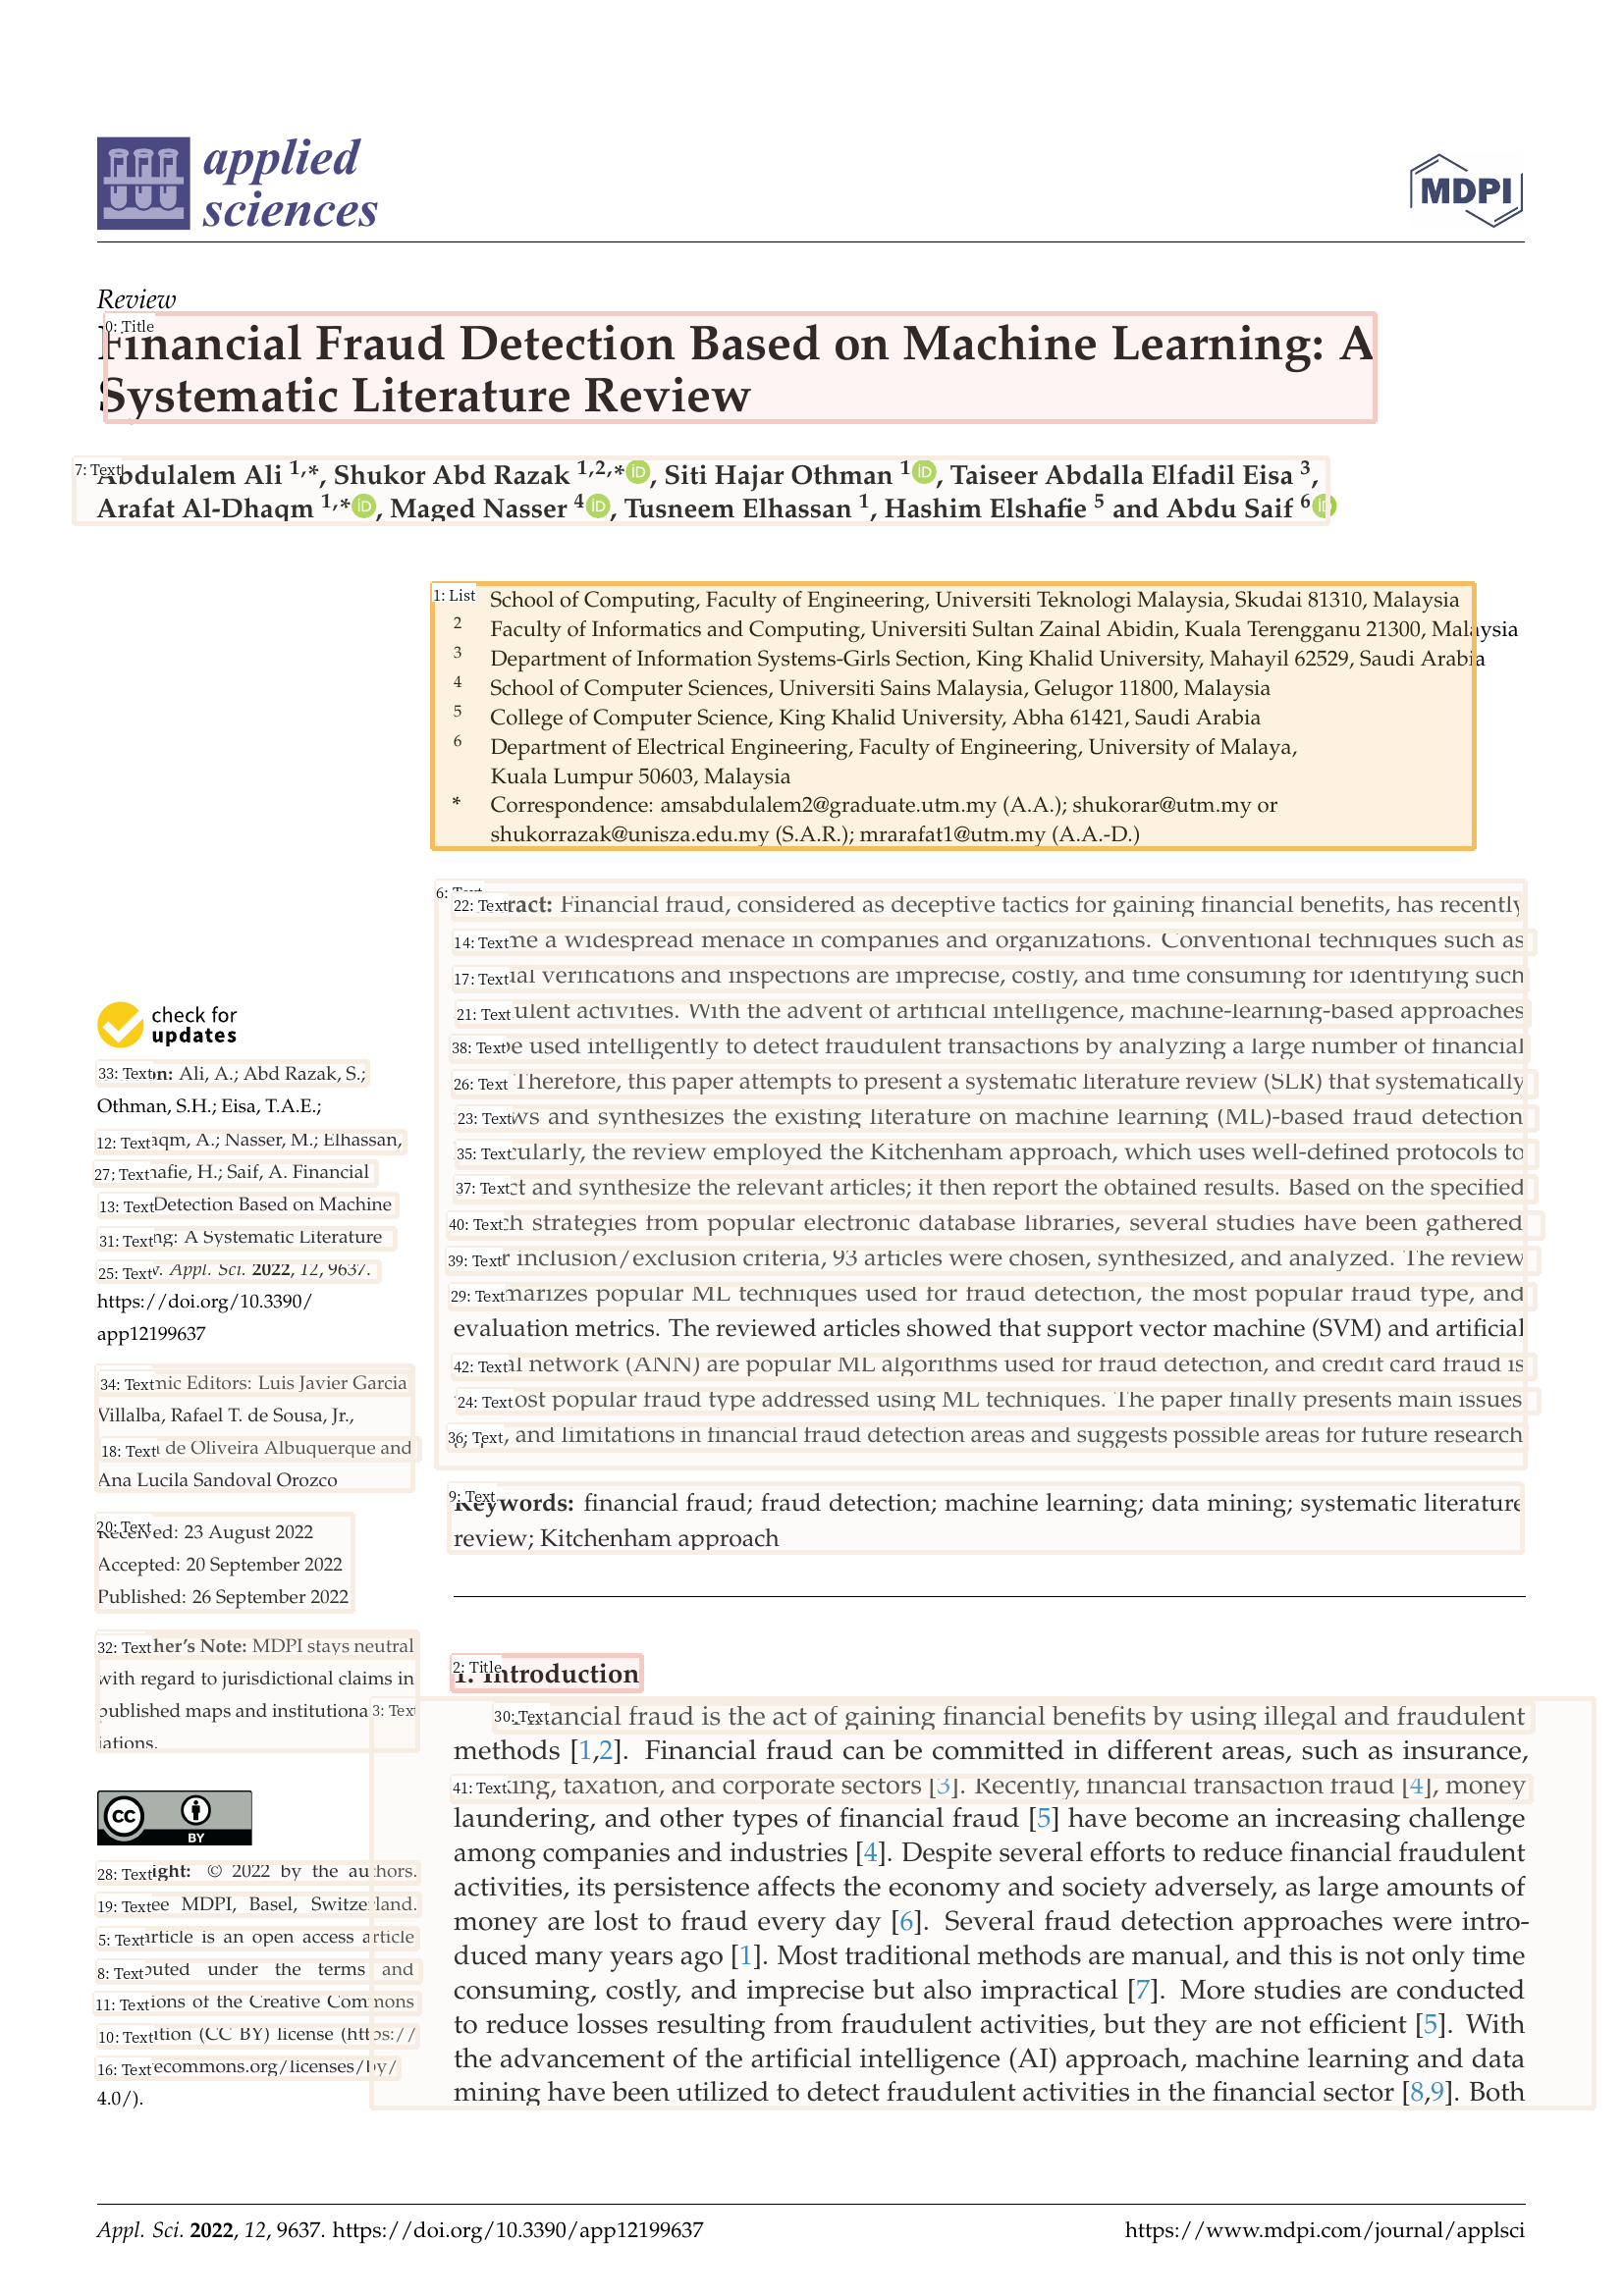

In [123]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

layout_result = model.detect(img)

# lp.draw_box(img, layout_result,  box_width=5, box_alpha=0.2, show_element_type=True)
text_blocks = lp.Layout([b for b in layout_result])

lp.draw_box(img
            , text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

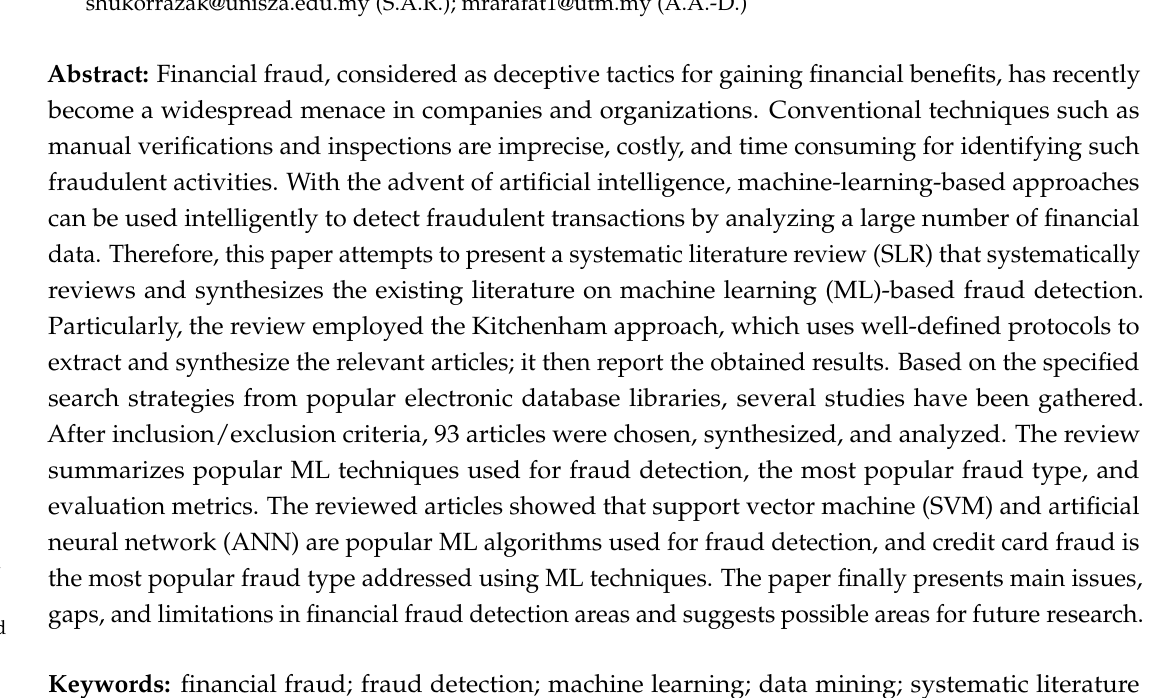

In [127]:
bbox= list(text_blocks[3].to_dict().values())
bbox
img.crop((bbox[0]-30, bbox[1]-50, bbox[2]+30, bbox[3]+50))

In [128]:
text_blocks[1].to_dict()

{'x_1': 99.08522033691406,
 'y_1': 1662.180908203125,
 'x_2': 425.7096252441406,
 'y_2': 1783.851318359375,
 'block_type': 'rectangle',
 'type': 'Text',
 'score': 0.9527534246444702}

# OCR Parser with Tesseract

In [129]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [134]:
text_blocks = lp.Layout([b for b in layout_result if b.type in ['Text', "List"]])
figure_blocks = lp.Layout([b for b in layout_result if b.type=='Figure'])

In [135]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [136]:
w, h  = img.size

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(img)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

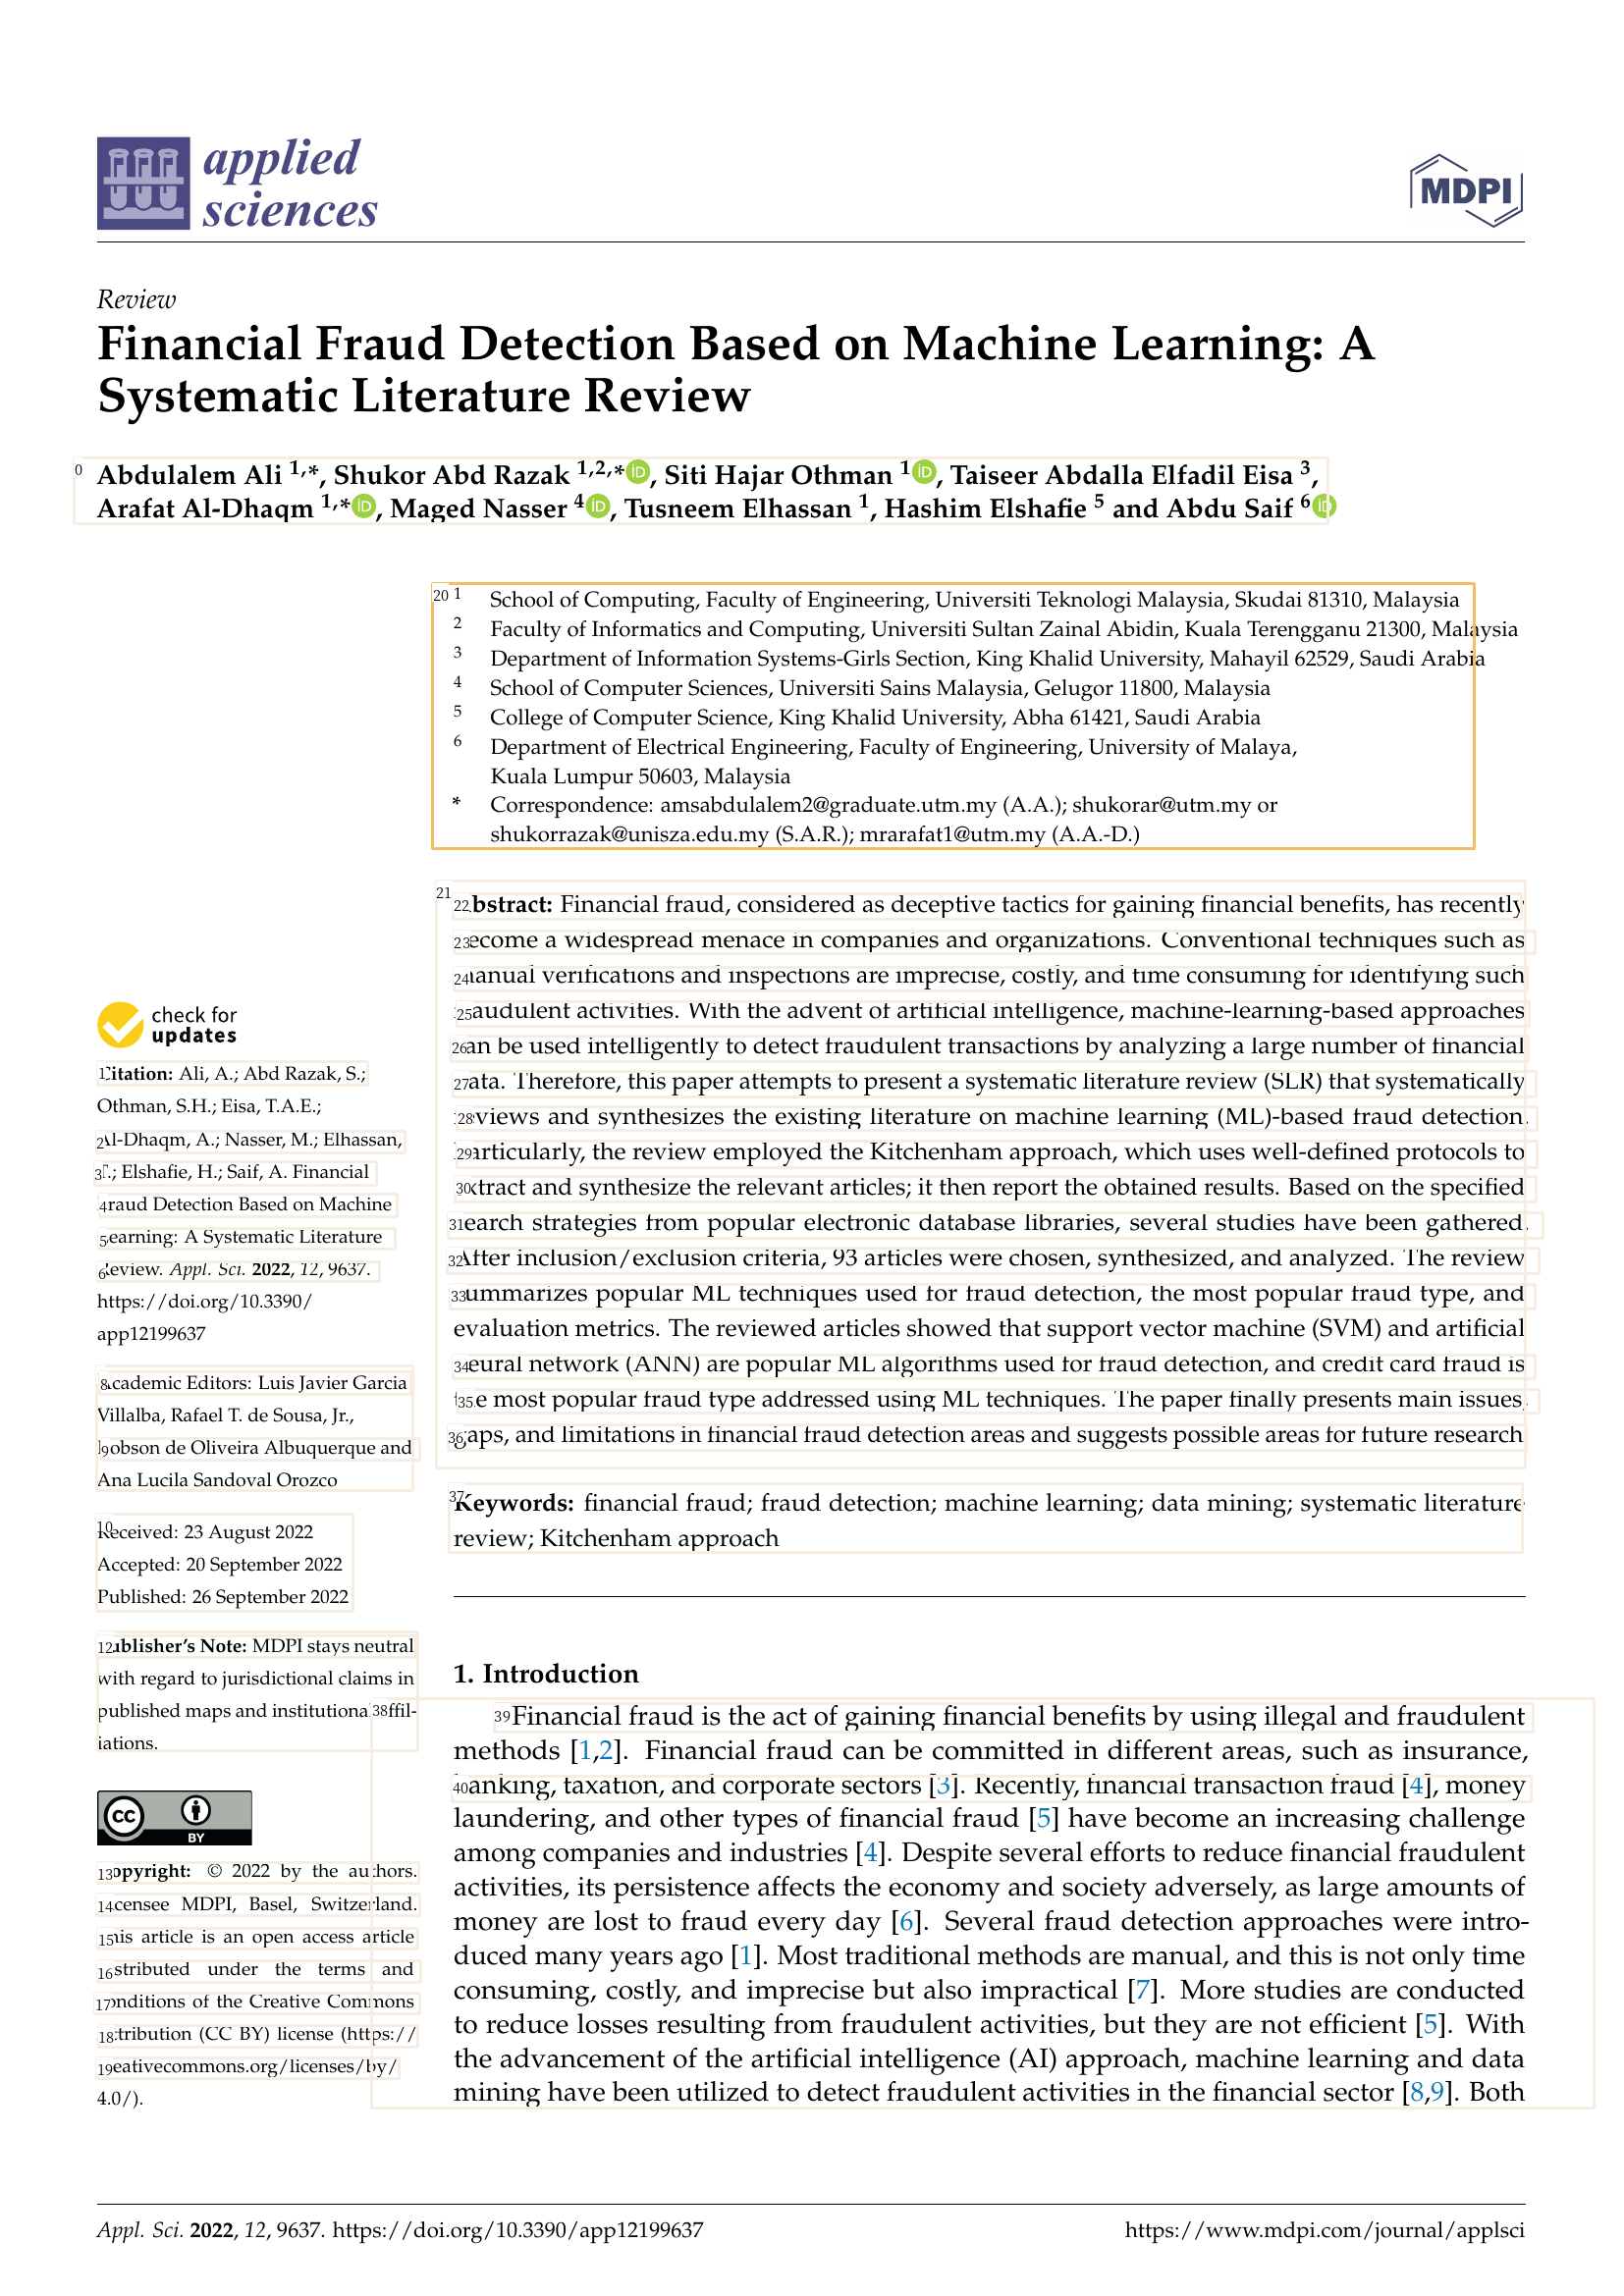

In [137]:
lp.draw_box(img, text_blocks,
            box_width=3,
            show_element_id=True)

In [141]:
ocr_agent = lp.TesseractAgent(languages='eng')
for block in text_blocks:
    segment_image = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(img1))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Abdulalem Ali !*, Shukor Abd Razak 12-*®, Siti Hajar Othman 1@, Taiseer Abdalla Elfadil Eisa 3,
Arafat Al-Dhaqm '*©, Maged Nasser +®, Tusneem Elhassan !, Hashim Elshafie > and Abdu Saif °©

---
Citation: Ali, A.; Abd Razak, S.;

 

---
Al-Dhaqm, A.; Nasser, M.; Elhassan,

---
T,; Elshafie, H.; Saif, A. Financial

---
Fraud Detection Based on Machine

---
Learning: A Systematic Literature

---
Review. Appl. Sci. 2022, 12, 9637.

---
Academic Editors: Luis Javier Garcia
Villalba, Rafael T. de Sousa, Jr.,
Robson de Oliveira Albuquerque and

Ana Lucila Sandoval Orozco

---
Academic Editors: Luis Javier Garcia

---
Robson de Oliveira Albuquerque and

---
Received: 23 August 2022
Accepted: 20 September 2022
Published: 26 September 2022

---
Publisher’s Note: MDPI stays neutral
with regard to jurisdictional claims in
published maps and institutional affil-

iations.

---
Publisher’s Note: MDPI stays neutral

---
Copyright: © 2022 by the authors.

---
Licensee MDPI, Basel, Switze

In [ ]:
# https://layout-parser.readthedocs.io/en/latest/example/deep_layout_parsing/index.html - reference 